In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import math
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
import hpc_reports
#
# def running_mean(X,n=10):
#     return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
# #

In [3]:
n_cpus = 4
print('** epoch: {}'.format(mpd.get_epoch()))
n_cpus = int(os.environ.get('SLURM_CPUS_PER_TASK',4))


** epoch: 1970-01-01T00:00:00


In [8]:
N_report_len = 180
end_dtm = dtm.datetime(2022,7,6)
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=N_report_len)
print('*** dates: {} - {}'.format(start_date, end_date))
partition='serc'
#partition=None
group=None
s_user=None
verbose=0
# group='oneillm'
# group='edunham'
#s_user = 'labraha2'
#
sacct_h5_file = f'sacct_data/sacct_p{str(partition).upper()}_g{str(group).upper()}_u{s_user}_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
print(f'*** sacct_h5_file: {sacct_h5_file}')
# NOTE: to get individual users, eg to get Eric's group usage:
#. sacct --allusers --user=labraha2 --start=2022-01-01 --end=2022-06-15
#
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=group, partition=partition, start_date=str(start_date),
                                          n_cpu=n_cpus, verbose=verbose,
                                          end_date=str(end_date), keep_raw_data=False)
    # , sacct_user=s_user
    print(f'** writing HDF5: {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
    #
#

*** dates: 2022-01-07 - 2022-07-06
*** sacct_h5_file: sacct_data/sacct_pSERC_gNONE_uNone_20220107_20220706.h5
*** Creating SACCT object from HDF5 sacct_data/sacct_pSERC_gNONE_uNone_20220107_20220706.h5


In [9]:
print('** ', SACCT_obj.jobs_summary.dtype.names)
print('\n** ', SACCT_obj.jobs_summary.dtype)
print('\n** ', SACCT_obj.n_cpu, type(SACCT_obj.n_cpu))

**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent')

**  [('index', '<i8'), ('User', 'S8'), ('Group', 'S8'), ('GID', 'S6'), ('JobName', 'S81'), ('JobID', 'S67'), ('JobIDRaw', 'S8'), ('Partition', 'S4'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'S9'), ('Suspended', 'S8'), ('ReqTRES', 'S49'), ('AllocTRES', 'S61'), ('MaxRSS', '<f8'), ('AveRSS', '<f8'), ('AveVMSize', '<f8'), ('MaxVMSize', '<f8'), ('MaxDiskWrite', '<f8'), ('MaxDiskR

In [18]:

print('** ', SACCT_obj.jobs_summary.dtype)
print('** ', type(SACCT_obj.jobs_summary['User'][0]))
#
my_ary = numpy.array(len(SACCT_obj.jobs_summary), dtype=SACCT_obj.jobs_summary.dtype)
print('** ', my_ary.dtype)
#
for cl,tp in SACCT_obj.jobs_summary.dtype.descr:
    print('** ', cl, tp)
    

print('** ** ', SACCT_obj.jobs_summary['Group'].astype(str)[0])


**  [('index', '<i8'), ('User', 'S8'), ('Group', 'S8'), ('GID', 'S6'), ('JobName', 'S81'), ('JobID', 'S67'), ('JobIDRaw', 'S8'), ('Partition', 'S4'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'S9'), ('Suspended', 'S8'), ('ReqTRES', 'S49'), ('AllocTRES', 'S61'), ('MaxRSS', '<f8'), ('AveRSS', '<f8'), ('AveVMSize', '<f8'), ('MaxVMSize', '<f8'), ('MaxDiskWrite', '<f8'), ('MaxDiskRead', '<f8'), ('AveDiskWrite', '<f8'), ('AveDiskRead', '<f8'), ('JobID_parent', 'S67')]
**  <class 'numpy.bytes_'>
**  [('index', '<i8'), ('User', 'S8'), ('Group', 'S8'), ('GID', 'S6'), ('JobName', 'S81'), ('JobID', 'S67'), ('JobIDRaw', 'S8'), ('Partition', 'S4'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f

**  [6.52947800e+09 6.53311300e+09 6.53386000e+09 6.80350550e+10
 1.50968000e+08 3.54979965e+11 4.59378640e+10 4.99879460e+10
 4.16474490e+10 7.18013300e+10]
*** quantiles:  [4.393000e-03 6.545404e+00 7.112037e+00 7.290471e+00]
*** DEBUG: 5000, None
*** DEBUG: 5000, None


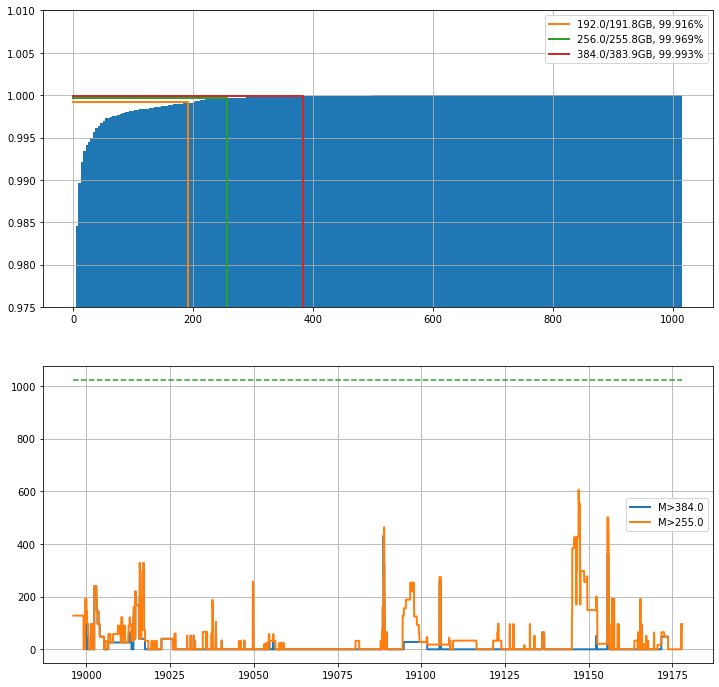

In [20]:
print('** ', SACCT_obj.jobs_summary['MaxRSS'][0:10])
fg = plt.figure(figsize=(12,12))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,1,2)
ax1.grid()
ax2.grid()
#
ix = numpy.invert(numpy.isnan(SACCT_obj.jobs_summary['MaxRSS']))
X  = SACCT_obj.jobs_summary['MaxRSS'][ix]
X /= float(1E9)
X.sort()
RSS_qs = numpy.quantile(X, [.1, .5, .75, .9])
print('*** quantiles: ', RSS_qs)
#
# note: we don't really do anything with these x_n bits...
x_250 = numpy.searchsorted(sorted(X), 256)
x_384 = numpy.searchsorted(sorted(X), 384)
#
hh = ax1.hist(X[X>RSS_qs[0]], bins=250,  cumulative=True, density=True)
#ax1.set_xlim(RSS_qs[1],1.1*numpy.nanmax(SACCT_obj.jobs_summary['MaxRSS']))
#
N = len(X)
for m in [192., 256., 384.]:
    k = numpy.searchsorted(X,m)-1
    p = k/N
    x = X[k]
    #
    ax1.plot([x,x,0.], [0., p, p ], ls='-', lw=2., label=f'{m}/{x:.1f}GB, {100.*p:.3f}%')
#
ax1.set_ylim(.975, 1.01)
ax1.legend(loc=0)

#
prev = numpy.zeros()
for m in (384., 255.):
    ix_255 = SACCT_obj.jobs_summary['MaxRSS']>=(m*1E9)
    activity_bigmem = SACCT_obj.active_jobs_cpu(jobs_summary=SACCT_obj.jobs_summary[ix_255])
    x = activity_bigmem['time']
    ax2.plot(x, activity_bigmem['N_cpu'], ls='-', lw=2., label=f'M>{m}')
ax2.plot(x[::len(x)-1], numpy.ones(2)*8*128, ls='--')
ax2.legend(loc=0)

In [13]:
activity_bigmem.dtype.names

('time', 'N_jobs', 'N_cpu')

*** quantiles:  [0.252464 7.754072 8.233024 8.990564]
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None


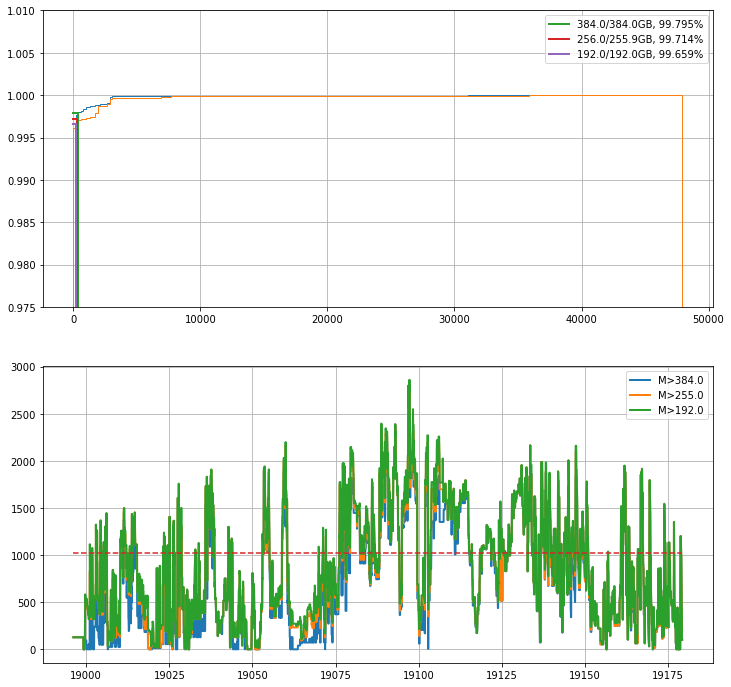

In [30]:
fg = plt.figure(figsize=(12,12))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,1,2)
ax1.grid()
ax2.grid()
#
col = 'MaxVMSize'
ix = numpy.invert(numpy.isnan(SACCT_obj.jobs_summary[col]))
X  = SACCT_obj.jobs_summary[col][ix]
X0 = X.copy()/1E9
X /= SACCT_obj.jobs_summary['NNodes'][ix]
X /= float(1E9)
X.sort()
RSS_qs = numpy.quantile(X, [.1, .5, .75, .9])
RSS0_qs = numpy.quantile(X0, [.1, .5, .75, .9])
print('*** quantiles: ', RSS_qs)
#
# note: we don't really do anything with these x_n bits...

hh = ax1.hist(X[X>RSS_qs[0]], bins=250, histtype='step',  cumulative=True, density=True)
hh = ax1.hist(X0[X0>RSS0_qs[0]], bins=250, histtype='step',  cumulative=True, density=True)
#ax1.set_xlim(RSS_qs[1],1.1*numpy.nanmax(SACCT_obj.jobs_summary['MaxRSS']))
#
N = len(X)
for m in [192., 256., 384.][::-1]:
    k = numpy.searchsorted(X,m)-1
    p = k/N
    x = X[k]
    #
    ax1.plot([x,x,0.], [0., p, p ], ls='-', lw=2., label=f'{m}/{x:.1f}GB, {100.*p:.3f}%')
#
ax1.set_ylim(.975, 1.01)
#ax1.set_xlim(-100.,10000.)
ax1.legend(loc=0)
#
for m in ( 384., 255., 192.):
    ix_255 = SACCT_obj.jobs_summary[col]>=(m*1E9)
    activity_bigmem = SACCT_obj.active_jobs_cpu(jobs_summary=SACCT_obj.jobs_summary[ix_255])
    x = activity_bigmem['time']
    ax2.plot(x, activity_bigmem['N_cpu'], ls='-', lw=2., label=f'M>{m}')
ax2.plot(x[::len(x)-1], numpy.ones(2)*8*128, ls='--')
ax2.legend(loc=0)

In [52]:
# IO Activity:
#
# date_range_to_timeseries(t_start=0, t_end=None, x_val=None, t0=0., dt=.1)
k=10
rw = SACCT_obj[k]
print('** rw: ', rw)
print('** **: ', rw['Start'], rw['End'])
print('** dtype: ', rw.dtype.names)
print('** ** DEBUG: ', rw['Start'], rw['End'], rw['MaxRSS'])
x = hpc_lib.date_range_to_timeseries(t_start=rw['Start'], t_end=rw['End'], x_val=rw['MaxRSS'])
print('** x[{}]:\n'.format(len(x)))
for xx in x:
    print('* ', xx)
print('** ** DEBUG: ', rw['Start'], rw['End'], rw['MaxRSS'])

** rw:  (34, b'ysp', b'beroza', b'18036', b'exp1_tr3', b'41880779_1', b'41880780', b'serc', b'TIMEOUT', 2., 32, 1, 18997.20391204, 18997.20392361, 18997.20511574, 18999.2053588, 2.00016204, 2.34953704e-06, 1.04166667e-07, 2.4537037e-06, 1., b'5530048', b'00:00:00', b'billing=77,cpu=32,gres/gpu=1,mem=120G,node=1', b'billing=77,cpu=32,gres/gpu=1,mem=120G,node=1', 5.3034356e+10, 5.3034356e+10, 7.0557968e+10, 7.0557968e+10, 2.313354e+10, 1.3288923e+11, 2.313354e+10, 1.3288923e+11, b'41880779_1')
** **:  18997.20511574074 18999.205358796295
** dtype:  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent')
** ** DEBUG:  18997.20511574074 18999.205358796295 530343

In [51]:
print(x.shape)

(21, 2)
